In [24]:
# Autoreload extension for Jupyter notebooks
%load_ext autoreload
%autoreload 2

# Manual reload
from importlib import reload

# Magic commands for inline plotting and high-res figures
%matplotlib inline
%config InlineBackend.figure_format ='retina'

# Standard library imports
import os
import sys
import pickle
from pprint import pprint

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rsmf.abstract_formatter
import seaborn as sns
from jupyterthemes import jtplot

# Custom modules (if needed)
# module_path = os.path.join(os.path.expanduser('~'), 'CustomModules')
# sys.path.append(module_path)
# from telegram_notify import notify
# from plotting_tools import error_band_plot, get_ax_data_range

# Add the parent directory to sys.path (if needed)
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent.parent))

# Pandas configurations
pd.set_option('display.max_rows', 1000)
idx = pd.IndexSlice

# Figure formatting
import rsmf
FIG_FORMATTER: rsmf.abstract_formatter.AbstractFormatter = rsmf.setup(
    r"\documentclass[a4paper,twocolumn,10pt,unpublished]{quantumarticle}"
)
COLORS = plt.get_cmap('tab10')

plt.rcParams.update({
    "axes.prop_cycle": plt.cycler("color", plt.cm.tab10.colors),
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.major.size": 3,
    "ytick.major.size": 3,
    "figure.constrained_layout.use": True,
    "figure.constrained_layout.h_pad": 0.02,
    "figure.constrained_layout.w_pad": 0.02,
    "figure.constrained_layout.hspace": 0.01,
    "figure.constrained_layout.wspace": 0.01,
    "legend.framealpha": 0.5,
})

# For in-line display of rsmf figures
import matplotlib
from matplotlib.backends.backend_pgf import FigureCanvasPgf
matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)
matplotlib.use('module://matplotlib_inline.backend_inline')

# Utility functions
def write_pickle(path, obj):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

def read_pickle(path):
    with open(path, 'rb') as f:
        obj = pickle.load(f)
    return obj

from simulations.analysis.plotting_helpers import error_band_plot, load_data, take_best_by_from_df_ps_dict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df_ps_dict = load_data(["bb_old"])

## pfail vs pabort

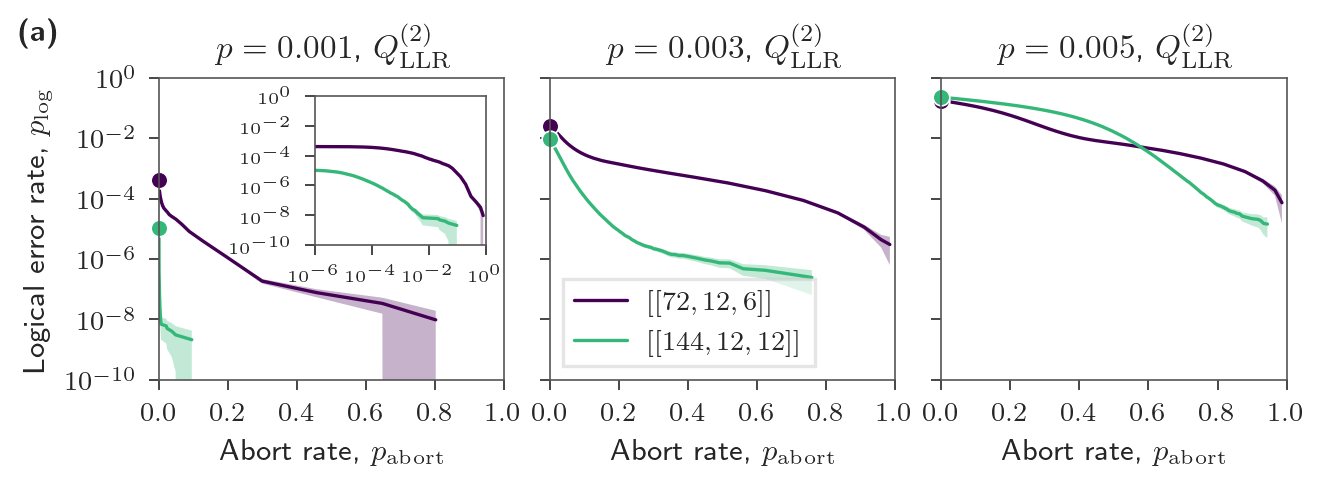

In [3]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig = FIG_FORMATTER.figure(wide=True, width_ratio=0.8, aspect_ratio=0.35)
axes = [fig.add_subplot(1, 3, 1)]
axes.extend([fig.add_subplot(1, 3, i + 1, sharey=axes[0]) for i in range(1, 3)])

p_values = [0.001, 0.003, 0.005]
nlist = [72, 144]
tol = 1

df_ps = df_ps_dict["cluster_llr_norm_frac_2"]

cmap = plt.get_cmap("viridis")


def create_mask(
    df: pd.DataFrame, value_col: str = "p_fail", error_col: str = "delta_p_fail"
) -> np.ndarray:
    upper_bound = df[value_col] + df[error_col]
    mask = np.ones(len(upper_bound), dtype=bool)
    # Vectorized approach: find where current value >= previous value
    non_decreasing = upper_bound.iloc[1:].values >= upper_bound.iloc[:-1].values
    mask[1:] = ~non_decreasing
    return mask


for i_p, p in enumerate(p_values):
    ax = axes[i_p]

    for i_n, n in enumerate(nlist):
        T = {144: 12, 72: 6}[n]
        df_ps_d = df_ps.loc[(n, T, p)].reset_index().sort_values("p_abort")
        df_ps_d = df_ps_d[create_mask(df_ps_d)]

        label = f"$[[144, 12, 12]]$" if n == 144 else f"$[[72, 12, 6]]$"
        p_abort = df_ps_d["p_abort"].values
        p_fail = df_ps_d["p_fail"].values
        delta_p_fail = df_ps_d["delta_p_fail"].values
        color = cmap(0) if i_n == 0 else cmap(2 / 3)
        error_band_plot(p_abort, p_fail, delta_p_fail, ax=ax, color=color, label=label)

        # df_ps_d_pred_llr = df_ps_dict["pred_llr"].loc[idx[n, T, p, :], :]
        # label = rf"$n={n}$ (correction weight)" if i_p == 0 else None
        # plot(df_ps_d_pred_llr, ax, T, label=label, color=COLORS(i_n), linestyle="--")

        # Find minimum p_abort and corresponding LER per round
        min_p_abort_idx = np.argmin(p_abort)
        min_p_abort = p_abort[min_p_abort_idx]
        min_ler_per_round = p_fail[min_p_abort_idx]

        # Plot marker at minimum p_abort
        ax.plot(
            min_p_abort,
            min_ler_per_round,
            marker="o",
            color=color,
            markersize=5,
            markeredgecolor="white",
            markeredgewidth=0.5,
            clip_on=False,
        )

    ax.set_xlim(0, 1)
    ax.set_xticks(np.arange(0, 1.1, 0.2))
    ax.set_yscale("log")
    ax.set_ylim(1e-10, 1)
    ax.set_yticks(10.0 ** np.arange(-10, 1, 2))
    ax.set_xlabel(r"Abort rate, $p_\mathrm{abort}$")
    ax.set_title(rf"$p = {p}$, $Q_\mathrm{{LLR}}^{{(2)}}$", fontsize=10)

    if i_p == 0:
        ax.set_ylabel(r"Logical error rate, $p_\mathrm{log}$")

    if i_p == 1:
        ax.legend(fontsize=8)

    if i_p > 0:
        ax.label_outer()

# Add inset to the first subplot after tight_layout
inset_ax = inset_axes(
    axes[0],
    width="50%",
    height="50%",
    loc="upper right",
    bbox_to_anchor=(0, 0, 0.99, 0.99),
    bbox_transform=axes[0].transAxes,
)

# Plot data on inset for the first subplot
p = p_values[0]
for i_n, n in enumerate(nlist):
    T = {144: 12, 72: 6}[n]
    df_ps_d = df_ps.loc[(n, T, p)].reset_index().sort_values("p_abort")
    df_ps_d = df_ps_d[create_mask(df_ps_d)]

    p_abort = df_ps_d["p_abort"].values
    p_fail = df_ps_d["p_fail"].values
    delta_p_fail = df_ps_d["delta_p_fail"].values
    color = cmap(0) if i_n == 0 else cmap(2 / 3)
    error_band_plot(
        p_abort,
        p_fail,
        delta_p_fail,
        color=color,
        ax=inset_ax,
    )

inset_ax.set_xscale("log")
inset_ax.set_yscale("log")
inset_ax.set_xlim(1e-6, 1)
inset_ax.set_xticks([1e-6, 1e-4, 1e-2, 1e0])
inset_ax.set_ylim(1e-10, 1)
inset_ax.set_yticks(10.0 ** np.arange(-10, 1, 2))
inset_ax.tick_params(labelsize=5)

fig.text(
    0,
    1,
    r"\textbf{(a)}",
    in_layout=False,
    transform=fig.transFigure,
    verticalalignment="top",
)


fig.savefig("overleaf_figs/bb_code_plog_vs_pabort.pdf")

In [ ]:
# def exclude(by):
#     if "cluster_llr_norm" in by or "cluster_size_norm" in by:
#         if "norm_gap" not in by:
#             return False
#     return True


# df_ps_best = take_best_by_from_df_ps_dict(
#     df_ps_dict,
#     exclude=exclude,
#     use_pfail_upper=False,
# )

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x105f6fb10>>
Traceback (most recent call last):
  File "/Users/slee7208/Research/USYD/24-PostSelectionDecoding/ldpc-post-selection/.venv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [ ]:
# df_ps_best.head()

p_fail  delta_p_fail  \
n  T p     p_abort                                
72 6 0.001 1.920730e-09  0.000398      0.000001   
           2.920729e-09  0.000398      0.000001   
           3.920730e-09  0.000398      0.000001   
           4.920729e-09  0.000398      0.000001   
           5.920729e-09  0.000398      0.000001   

                                                                        by  
n  T p     p_abort                                                          
72 6 0.001 1.920730e-09  cluster_size_norm_2,cluster_llr_norm_inf,clust...  
           2.920729e-09  cluster_llr_norm_0.5,cluster_size_norm_inf,clu...  
           3.920730e-09  cluster_size_norm_1,cluster_size_norm_inf,clus...  
           4.920729e-09  cluster_size_norm_0.5,cluster_size_norm_1,clus...  
           5.920729e-09  cluster_llr_norm_1,cluster_llr_norm_inf,cluste...

In [28]:
from simulations.analysis.plotting_helpers import (
    get_lower_envelope,
    error_band_plot,
)


def plot_plog_against_pabort(n, p, aspect_ratio=0.9):
    d = {144: 12, 72: 6}[n]

    fig = FIG_FORMATTER.figure(wide=True, width_ratio=0.32, aspect_ratio=aspect_ratio)
    ax = fig.add_subplot()

    def plot(df, intv=None, **kwargs):
        df = df.reset_index().sort_values("p_abort")
        df = df[create_mask(df)]

        get_values = lambda col: (
            df[col].values if intv is None else df[col].values[::intv]
        )

        p_abort = get_values("p_abort")
        p_fail = get_values("p_fail")
        delta_p_fail = get_values("delta_p_fail")
        error_band_plot(p_abort, p_fail, delta_p_fail, ax=ax, **kwargs)

    # Best cluster norm
    df_ps_d = df_ps_dict["cluster_llr_norm_frac_2"].loc[idx[n, d, p, :], :]
    plot(df_ps_d, label=r"$Q_\mathrm{LLR}^{(2)}$", intv=2, color=COLORS(0))

    # Prediction LLR
    plot(
        df_ps_dict["pred_llr"].loc[idx[n, d, p, :], :],
        label=rf"Correction weight",
        color=COLORS(2),
        linestyle="-.",
        intv=2,
    )

    # Detector density
    plot(
        df_ps_dict["detector_density"].loc[idx[n, d, p, :], :],
        label=rf"Detector density",
        color=COLORS(3),
        linestyle=":",
        intv=2,
    )

    # ax.set_xscale("log")
    code_prms = f"$[[144, 12, 12]]$" if n == 144 else f"$[[72, 12, 6]]$"
    ax.set_title(rf"{code_prms}, $p = {p}$", fontsize=10)
    ax.set_xlim(0, 1)
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.set_yscale("log")
    ax.legend(loc="lower left", fontsize=7)
    ax.set_ylim(1e-10, 1)

    ax.set_xlabel(r"Abort rate, $p_\mathrm{abort}$")
    ax.set_ylabel(r"Logical error rate, $p_\mathrm{log}$")

    return fig, ax

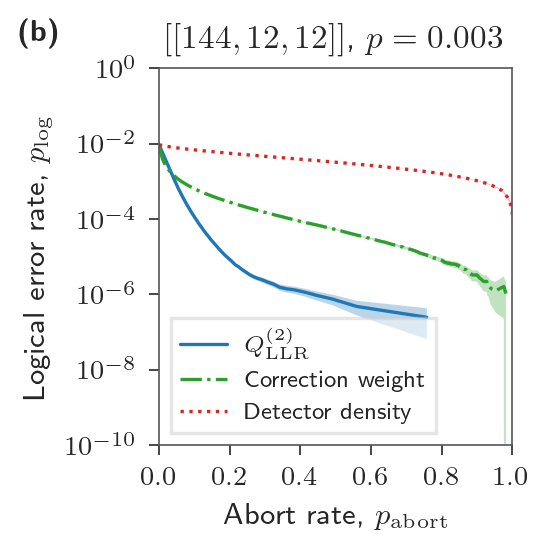

In [29]:
import matplotlib as mpl

fig, ax = plot_plog_against_pabort(144, 3e-3, aspect_ratio=1)
fig.text(
    0,
    1,
    r"\textbf{(b)}",
    in_layout=False,
    transform=fig.transFigure,
    verticalalignment="top",
)

fig.savefig(
    "overleaf_figs/bb_code_metric_comparison_plog_vs_pabort.pdf",
)

In [30]:
n = 144
T = {144: 12, 72: 6}[n]
p = 0.003


# Create ordered list of keys
ordered_keys = df_ps_dict.keys()

i = 0
data_plots = {}
for by in ordered_keys:
    try:
        df_ps = df_ps_dict[by].loc[idx[n, T, p, :], :]
    except KeyError:
        continue

    p_abort_col = "p_abort"
    p_fail_col = "p_fail"
    delta_p_fail_col = "delta_p_fail"

    df_ps = df_ps.sort_values(by=p_abort_col)
    p_abort = df_ps[p_abort_col].values
    p_fail = df_ps[p_fail_col].values
    delta_p_fail = df_ps[delta_p_fail_col].values
    data_plots[by] = (p_abort, p_fail, delta_p_fail)

0: cluster_llr_norm_frac_inf (2.29e-06 ± 3.53e-07)
1: cluster_size_norm_frac_inf (2.33e-06 ± 3.56e-07)
2: cluster_size_norm_frac_2 (2.35e-06 ± 3.58e-07)
3: cluster_llr_norm_frac_2 (2.40e-06 ± 3.60e-07)
4: cluster_llr_norm_frac_1 (2.56e-06 ± 3.72e-07)
5: cluster_size_norm_frac_1 (2.59e-06 ± 3.74e-07)
6: pred_llr (1.50e-04 ± 2.87e-06)
7: cluster_llr_norm_frac_0.5 (3.82e-03 ± 1.44e-05)
8: cluster_size_norm_frac_0.5 (4.22e-03 ± 1.52e-05)
9: detector_density (4.63e-03 ± 1.59e-05)


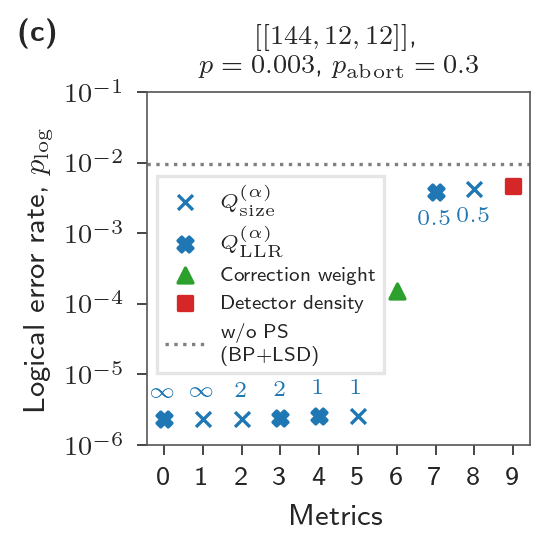

In [33]:
target = 0.3
bys, y_vals, y_errs = [], [], []

by_to_exclude = [
    "average_cluster_size",
    "average_cluster_llr",
    "matching_pred_llr",
    "matching_detector_density",
    "cluster_llr_residual_sum",
    "cluster_llr_residual_sum_gap",
]

for by, (p_abort, p_fail, delta_p_fail) in data_plots.items():
    if by in by_to_exclude:
        continue
    if "norm" in by and "frac" not in by:
        continue
    ind = np.where(p_abort <= target)[0]
    if len(ind):
        sel = ind[-1]
    else:
        sel = 0
    bys.append(by)
    y_vals.append(p_fail[sel])
    y_errs.append(delta_p_fail[sel])

sort_inds = np.argsort(y_vals)
by_sorted = [bys[i] for i in sort_inds]
y_vals_sorted = [y_vals[i] for i in sort_inds]
y_errs_sorted = [y_errs[i] for i in sort_inds]

for i, by in enumerate(by_sorted):
    print(f"{i}: {by} ({y_vals_sorted[i]:.2e} ± {y_errs_sorted[i]:.2e})")


def determine_group(by):
    if "matching" in by:
        group = 2
        color = COLORS(1)
        label = "Logical gap (MWPM)"
        marker = "o"
    elif "cluster_size_norm" in by:
        group = 0
        label = r"$Q_\mathrm{size}^{(\alpha)}$"
        marker = "x"
        color = COLORS(0)
    elif "cluster_llr_norm" in by:
        group = 1
        label = r"$Q_\mathrm{LLR}^{(\alpha)}$"
        marker = "X"
        color = COLORS(0)
    elif by == "pred_llr":
        group = 3
        label = "Correction weight"
        marker = "^"
        color = COLORS(2)
    elif by == "detector_density":
        group = 4
        label = "Detector density"
        marker = "s"
        color = COLORS(3)
    else:
        group = None
        label = "other"
        marker = "s"
        color = COLORS(5)
    return group, label, marker, color


# Group data and plot with different colors
group_labels_added = set()
legend_handles = []
legend_labels = []

fig = FIG_FORMATTER.figure(wide=True, width_ratio=0.32, aspect_ratio=1)
ax = fig.add_subplot()

for i, by in enumerate(by_sorted):
    group, group_label, marker, color = determine_group(by)
    assert group is not None
    label = group_label if group_label not in group_labels_added else None

    handle = ax.scatter(
        i,
        y_vals_sorted[i],
        marker=marker,
        s=20,
        color=color,
        label=label,
    )

    # Add number annotation for "norm" metrics
    if "norm" in by:
        norm_order = by.split("_")[-1]
        if norm_order == "inf":
            norm_order = r"$\infty$"
        else:
            norm_order = rf"${norm_order}$"

        if norm_order != rf"$0.5$":
            y_text = y_vals_sorted[i] * 1.8
        else:
            y_text = y_vals_sorted[i] * 0.3

        ax.text(
            i,
            y_text,  # Position slightly above the marker
            norm_order,
            ha="center",
            va="bottom",
            fontsize=6.5,
            color=color,
        )

    if label:
        group_labels_added.add(group_label)
        legend_handles.append((group, handle))
        legend_labels.append((group, group_label))

pfail_org = df_ps_dict["cluster_llr_norm_1"].loc[idx[n, T, p, :], "p_fail"].values[-1]

line = ax.axhline(pfail_org, color="grey", linestyle=":", label="BP+LSD")


# Sort legend by group order
legend_handles.sort(key=lambda x: x[0])
legend_labels.sort(key=lambda x: x[0])

legend_handles.append((999, line))  # Use high number to put at end
legend_labels.append((999, "w/o PS\n(BP+LSD)"))

ax.set_title(
    rf"$[[144, 12, 12]]$," + "\n" + rf"$p = {p}$, $p_\mathrm{{abort}} = {target}$",
    fontsize=8,
)
ax.set_xticks(np.arange(len(by_sorted)))
ax.set_xticklabels(np.arange(len(by_sorted)))
ax.set_xlabel("Metrics")
ax.set_ylabel(r"Logical error rate, $p_\mathrm{log}$")
ax.set_yscale("log")
ax.set_ylim(1e-6, 1e-1)
ax.set_yticks(10.0 ** np.arange(-6, 0, 1))

ax.legend(
    [h[1] for h in legend_handles],
    [l[1] for l in legend_labels],
    loc="upper left",
    bbox_to_anchor=(0, 0.79),
    fontsize=6,
)


fig.text(
    0,
    1,
    r"\textbf{(c)}",
    in_layout=False,
    transform=fig.transFigure,
    verticalalignment="top",
)

plt.savefig("overleaf_figs/bb_code_metric_comparison.pdf")

## Abort rate to achieve a target logical error rate

In [34]:
df_ps_dict = load_data(["bb"])
df_ps = df_ps_dict["cluster_llr_norm_2"]
df_ps.head()

p_fail  delta_p_fail   p_abort  \
n  T p     cluster_llr_norm                                         
72 6 0.001 0.00              2.929323e-07  2.929323e-07  0.934431   
           5.63              1.647194e-07  1.647194e-07  0.883394   
           5.91              1.560664e-07  1.560664e-07  0.876929   
           6.36              1.205157e-07  1.205157e-07  0.840624   
           6.62              1.058061e-07  1.058061e-07  0.818467   

                             delta_p_abort     count  num_fails  p_fail_conv  \
n  T p     cluster_llr_norm                                                    
72 6 0.001 0.00                   0.000049   6556902          0     0.000027   
           5.63                   0.000063  11660613          0     0.000027   
           5.91                   0.000064  12307126          0     0.000027   
           6.36                   0.000072  15937580          0     0.000027   
           6.62                   0.000076  18153292          0     0.000027   

                             delta_p_fail_conv  p_abort_conv  \
n  T p     cluster_llr_norm                                    
72 6 0.001 0.00                       0.000001      0.158496   
           5.63                       0.000001      0.158496   
           5.91                       0.000001      0.158496   
           6.36                       0.000001      0.158496   
           6.62                       0.000001      0.158496   

                             delta_p_abort_conv  count_conv  num_fails_conv  
n  T p     cluster_llr_norm                                                  
72 6 0.001 0.00                        0.000072  84150422.0            2247  
           5.63                        0.000072  84150422.0            2247  
           5.91                        0.000072  84150422.0            2247  
           6.36                        0.000072  84150422.0            2247  
           6.62                        0.000072  84150422.0            2247

In [ ]:
from simulations.analysis.plotting_helpers import get_required_abort_rate


def plot_required_abort_rate(
    by,
    target_suppression,
    fix_ler=False,
    plot_cost=False,
    ler_per_round=True,
    ax=None,
    title="default",
    show_only_plots=False,
    plot_kwargs=None,
    p_max=None,
):
    df_ps = df_ps_dict[by]

    plist = df_ps.index.get_level_values("p").unique()
    if p_max is not None:
        plist = plist[plist <= p_max]

    results = []

    for n in [72, 144]:
        T = {72: 6, 144: 12}[n]
        for p in plist:
            df_ps_sng = df_ps.loc[(n, T, p)]
            if fix_ler:
                target_ler = target_suppression
                if ler_per_round:
                    target_ler *= T
                results_sng = get_required_abort_rate(df_ps_sng, target_ler=target_ler)

            else:
                results_sng = get_required_abort_rate(
                    df_ps_sng, target_suppression=target_suppression
                )

            p_abort = results_sng["p_abort"]
            p_abort_lower = results_sng["p_abort_low"]
            p_abort_upper = results_sng["p_abort_upp"]

            results.append(
                {
                    "n": n,
                    "T": T,
                    "p": p,
                    "p_abort": p_abort,
                    "p_abort_lower": p_abort_lower,
                    "p_abort_upper": p_abort_upper,
                }
            )

    # Convert results to DataFrame for plotting
    results_df = pd.DataFrame(results)

    if plot_cost:
        T_all = results_df["T"]
        n_all = results_df["n"]
        cost = (2 * n_all - 12) * T_all
        results_df["cost"] = cost / (1 - results_df["p_abort"])
        results_df["cost_lower"] = cost / (1 - results_df["p_abort_lower"])
        results_df["cost_upper"] = cost / (1 - results_df["p_abort_upper"])

    # Create axes if not provided
    if ax is None:
        fig, ax = plt.subplots(layout="constrained")

    for n in [72, 144]:
        data_n = results_df[results_df["n"] == n]
        data_n = data_n.sort_values("p_abort")
        last_zero_lower_idx = data_n[data_n["p_abort_lower"] < 1e-5].index
        first_one_upper_idx = data_n[data_n["p_abort_upper"] > 1 - 1e-5].index

        if len(last_zero_lower_idx) > 0 and len(first_one_upper_idx) > 0:
            start_idx = last_zero_lower_idx[-1]  # Last row where p_abort_lower is 0
            end_idx = first_one_upper_idx[0]  # First row where p_abort_upper is 1
            data_n = data_n.loc[start_idx:end_idx]
        elif len(last_zero_lower_idx) > 0:
            # If no p_abort_upper == 1, start from last p_abort_lower == 0
            start_idx = last_zero_lower_idx[-1]
            data_n = data_n.loc[start_idx:]
        elif len(first_one_upper_idx) > 0:
            # If no p_abort_lower == 0, end at first p_abort_upper == 1
            end_idx = first_one_upper_idx[0]
            data_n = data_n.loc[:end_idx]

        if not data_n.empty:
            col = "cost" if plot_cost else "p_abort"
            col_lower = "cost_lower" if plot_cost else "p_abort_lower"
            col_upper = "cost_upper" if plot_cost else "p_abort_upper"

            delta_y_lower = data_n[col] - data_n[col_lower]
            delta_y_upper = data_n[col_upper] - data_n[col]

            mask = delta_y_upper != np.inf

            label = r"$[[144, 12, 12]]$" if n == 144 else r"$[[72, 12, 6]]$"
            kwargs = {
                "marker": "o",
                "capsize": 3,
                "capthick": 1,
                "barsabove": True,
                "label": label,
            }
            if plot_kwargs is not None:
                kwargs.update(plot_kwargs[n])

            ax.errorbar(
                data_n["p"][mask],
                data_n[col][mask],
                yerr=[
                    delta_y_lower[mask],
                    delta_y_upper[mask],
                ],
                **kwargs,
            )

    ax.set_xlim(0, 6e-3)
    if not plot_cost:
        ax.set_ylim(0, 1)

    if not show_only_plots:
        ax.set_xlabel(r"Physical error rate, $p$")
        ax.set_ylabel(r"Required abort rate, $p_\mathrm{abort}$")
        if title == "default":
            if fix_ler:
                ax.set_title(
                    rf"Target $p_\mathrm{{log}} = {target_suppression}$" + f"\nby={by}"
                )
            else:
                ax.set_title(
                    rf"Target Suppression = {target_suppression}" + f"\nby={by}"
                )
        elif title:
            ax.set_title(title)
        ax.legend()
    return ax

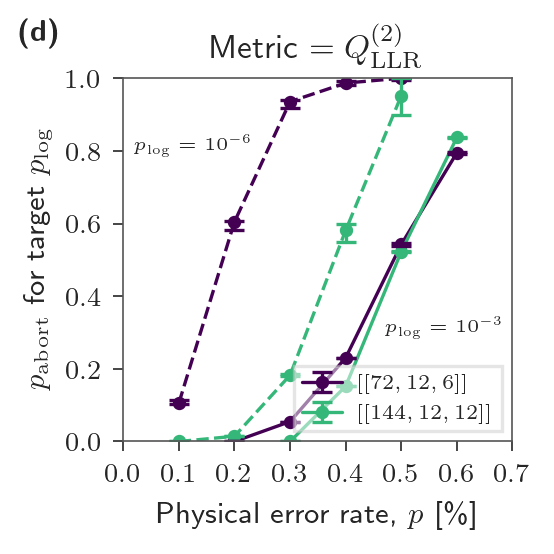

In [43]:
fig = FIG_FORMATTER.figure(wide=True, width_ratio=0.32, aspect_ratio=1)
ax = fig.add_subplot()

target_lers = [1e-3, 1e-6]

cmap = plt.get_cmap("viridis")
colors = [cmap(0), cmap(2 / 3)]

for i, target_ler in enumerate(target_lers):
    plot_kwargs = {}
    for i_n, n in enumerate([72, 144]):
        if i == 0:
            label = r"$[[144, 12, 12]]$" if n == 144 else r"$[[72, 12, 6]]$"
        else:
            label = None
        if i == 0:
            linestyle = "-"
        else:
            linestyle = "--"

        plot_kwargs_n = {
            "color": colors[i_n],
            "linestyle": linestyle,
            "label": label,
        }
        plot_kwargs[n] = plot_kwargs_n

    plot_required_abort_rate(
        "cluster_llr_norm_2",
        target_ler,
        ax=ax,
        fix_ler=True,
        title=False,
        show_only_plots=True,
        plot_kwargs=plot_kwargs,
    )

ax.text(0.0047, 0.3, r"$p_\mathrm{log} = 10^{-3}$", fontsize=5.5)
ax.text(0.00019, 0.8, r"$p_\mathrm{log} = 10^{-6}$", fontsize=5.5)

ax.set_xlabel(r"Physical error rate, $p$ [\%]")
ax.set_ylabel(r"$p_\mathrm{abort}$ for target $p_\mathrm{log}$")
ax.set_xlim(0, 7e-3)
xticks = np.arange(0, 7.1e-3, 1e-3)
xtick_labels = [rf"${xtick * 100:.1f}$" for xtick in xticks]
ax.set_xticks(xticks, xtick_labels)
ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.1, 0.2))

ax.legend(fontsize=6, loc="lower right")
ax.set_title(r"Metric $= Q_\mathrm{LLR}^{(2)}$", fontsize=10)

fig.text(
    0,
    1,
    r"\textbf{(d)}",
    in_layout=False,
    transform=fig.transFigure,
    verticalalignment="top",
)

fig.savefig("overleaf_figs/bb_code_target_ler.pdf")

/Users/slee7208/Research/USYD/24-PostSelectionDecoding/ldpc-post-selection/.venv/lib/python3.11/site-packages/matplotlib/axes/_axes.py:3825: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.vstack([-(1 - lolims), 1 - uplims]) * err
/Users/slee7208/Research/USYD/24-PostSelectionDecoding/ldpc-post-selection/.venv/lib/python3.11/site-packages/matplotlib/axes/_axes.py:3825: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.vstack([-(1 - lolims), 1 - uplims]) * err


Text(0, 1, '(d)')

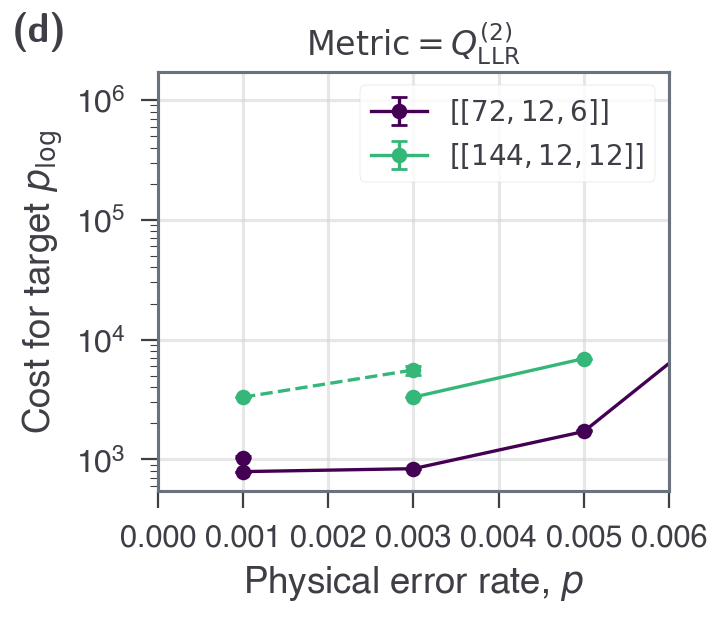

In [202]:
from matplotlib.ticker import ScalarFormatter

fig, ax = plt.subplots(figsize=(DFT_FIG_WIDTH_WIDE * 0.32, 3), layout="constrained")

target_lers = [1e-3, 1e-7]

cmap = plt.get_cmap("viridis")
colors = [cmap(0), cmap(2 / 3)]

for i, target_ler in enumerate(target_lers):
    plot_kwargs = {}
    for i_n, n in enumerate([72, 144]):
        if i == 0:
            label = r"$[[144, 12, 12]]$" if n == 144 else r"$[[72, 12, 6]]$"
        else:
            label = None
        if i == 0:
            linestyle = "-"
        else:
            linestyle = "--"

        plot_kwargs_n = {
            "color": colors[i_n],
            "linestyle": linestyle,
            "label": label,
        }
        plot_kwargs[n] = plot_kwargs_n

    plot_required_abort_rate(
        "cluster_llr_norm_2",
        target_ler,
        ax=ax,
        fix_ler=True,
        plot_cost=True,
        ler_per_round=False,
        title=False,
        show_only_plots=True,
        plot_kwargs=plot_kwargs,
    )

# ax.text(0.0041, 0.25, r"$\frac{p_\mathrm{log}}{T} = 10^{-4}$", fontsize=10)
# ax.text(0.0001, 0.5, r"$\frac{p_\mathrm{log}}{T} = 10^{-7}$", fontsize=10)

ax.set_xlabel(r"Physical error rate, $p$")
ax.set_ylabel(r"Cost for target $p_\mathrm{log}$")
ax.set_xlim(0, 6e-3)
ax.set_xticks(np.arange(0, 6.1e-3, 1e-3))
# ax.set_ylim(0, 1)
ax.set_yscale("log")
ax.tick_params(axis="x", labelsize=11)

# fmt = ScalarFormatter(useMathText=True)
# fmt.set_powerlimits((-3, -3))
# ax.xaxis.set_major_formatter(fmt)

ax.legend(fontsize=10)
ax.set_title(r"$\text{Metric} = Q_\mathrm{LLR}^{(2)}$", fontsize=12)

ax.text(
    0,
    1,
    "(d)",
    transform=fig.transFigure,
    fontdict=dict(weight="bold", family=CMU_FONT),
    va="top",
    ha="left",
    in_layout=False,
    fontsize=14,
)

# fig.savefig("overleaf_figs/bb_code_target_ler.pdf")

## Cluster statstics

In [35]:
df_agg_dict = load_data("bb", "agg")

Text(0.5, 0, 'Cluster LLR norm (order = 2)')

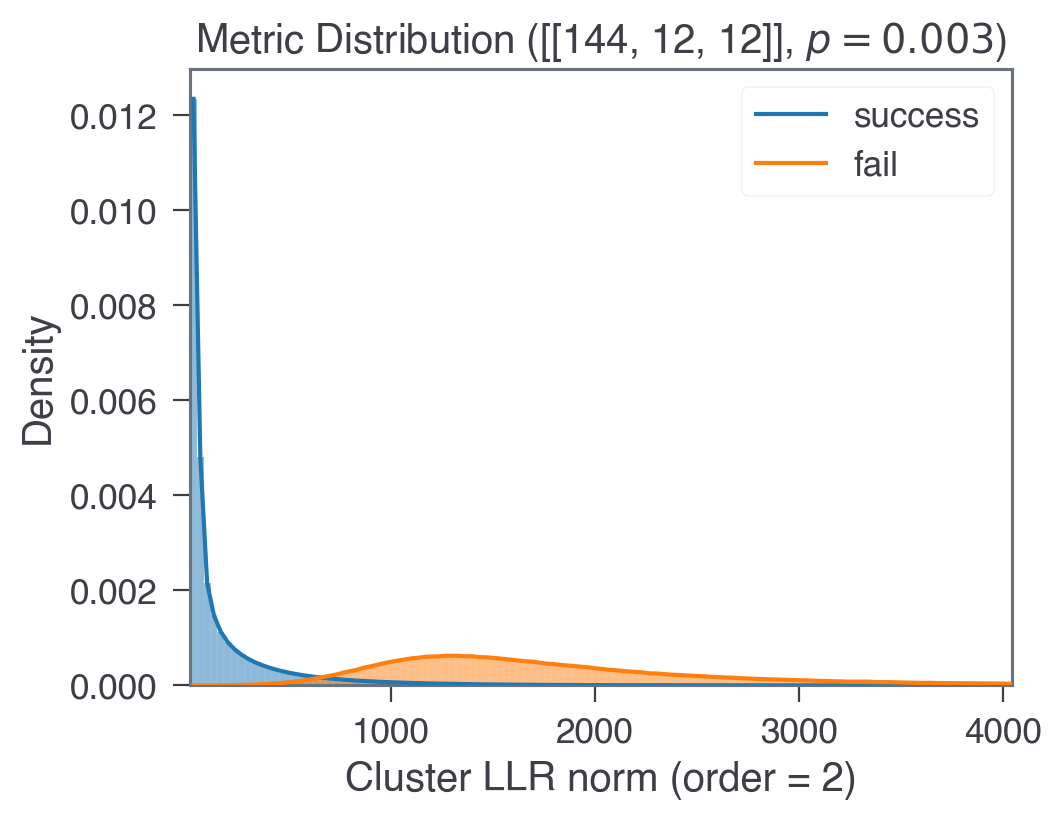

In [ ]:
import matplotlib.pyplot as plt
from simulations.analysis.plotting_helpers import plot_success_failure_histogram

by = "cluster_llr_norm_2"
# by = "matching_gap"
# by = "pred_llr"
n = 144
n = {72: 6, 144: 12}[n]
p = 3e-3

df_agg = df_agg_dict[by].loc[(n, n, p)]

fig, ax = plt.subplots(figsize=(DFT_FIG_WIDTH, 4))

plot_success_failure_histogram(
    df_agg,
    bins=1000,
    colors=[COLORS(0), COLORS(1)],
    # rescale_by_rate=True,
    # twin_y=True,
    alpha=0.5,
    ax=ax,
    upper_trim_frac=5e-2,
)

ax.set_title(rf"Metric Distribution ([[144, 12, 12]], $p = {p}$)")
ax.set_xlabel(r"Cluster LLR norm (order = 2)")